In [1]:
# !pip install 'zarr<3'
# !pip install timm
# !pip install openslide-python tiffslide
# !pip install cupy-cuda12x  # for CUDA 12.x
# !pip install geopandas pyarrow

In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")


✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## WSI Flex

In [3]:
import torch
from vitaminp import VitaminPFlex
from vitaminp.inference import ChannelConfig, WSIPredictor
# Setup model
device = 'cuda'
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold21_best.pth", map_location=device))
model.eval()

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]


VitaminPFlex(
  (backbone): DINOv2Backbone(
    (dinov2): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): M

In [4]:
from vitaminp.inference import WSIPredictor
from vitaminp.inference.channel_config import ChannelConfig

# 1. Setup Model (Standard)
# model = ... (load your model as usual)

# 2. Initialize Predictor
predictor = WSIPredictor(
    model=model,
    device='cuda',
    patch_size=512,
    overlap=64,
    target_mpp=0.263,
    magnification=40,
    batch_size=128
)

# 3. RUN INFERENCE (The Magic Step)
# By passing BOTH branches, the predictor automatically switches to 
# the new "Joint Inference" mode where Nuclei constrain the Cells.
results = predictor.predict(
    wsi_path='test_images/CRC18-he_chunk_0.png',
    output_dir='results_joint_constrained',
    
    # [!] THIS TRIGGERS THE NEW LOGIC
    branches=['he_nuclei', 'he_cell'], 
    
    # Standard settings
    filter_tissue=False,
    clean_overlaps=True,
    save_geojson=True,
    save_parquet=False,       # Saves fast-loading parquet files
    simplify_epsilon=None,    # Smoother contours
    coord_precision=None,        # Smaller file size
)


2026-02-03 23:57:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-02-03 23:57:05 - WSIPredictor - INFO -   Device: cuda
2026-02-03 23:57:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-02-03 23:57:05 - WSIPredictor - INFO -   Batch Size: 128
2026-02-03 23:57:05 - WSIPredictor - INFO - 🔍 Resolution: MPP=0.2630, scale=1.00x, Batch Size=128
2026-02-03 23:57:05 - WSIPredictor - INFO - 🧠 Running Batch Inference...


   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...


Processing: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
2026-02-03 23:57:06 - WSIPredictor - INFO -    ✓ Extracted 218 instances (before cleaning)
2026-02-03 23:57:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-02-03 23:57:06 - WSIPredictor - INFO -    🔍 Starting with 218 instances
2026-02-03 23:57:06 - WSIPredictor - INFO -    📍 Phase 1: Hard Drop (directional boundary cleaning)
2026-02-03 23:57:06 - WSIPredictor - INFO -    ✓ Hard Drop removed 0, survivors: 218
2026-02-03 23:57:06 - WSIPredictor - INFO -    🔄 Phase 2: Iterative overlap removal
2026-02-03 23:57:06 - WSIPredictor - INFO -       Iteration 1: 0 overlaps, kept 218/218
2026-02-03 23:57:06 - WSIPredictor - INFO -       ✓ Converged!
2026-02-03 23:57:06 - WSIPredictor - INFO -    ✅ Final count: 218 instances
2026-02-03 23:57:06 - WSIPredictor - INFO -    ✓ Removed 0, remaining: 218
2026-02-03 23:57:07 - WSIPredictor - INFO - ✅ he_nuclei: 218 detections
2026-02-03 23:57:07 - WSIPredict

## figure

PDF saved with white background for Adobe Illustrator.


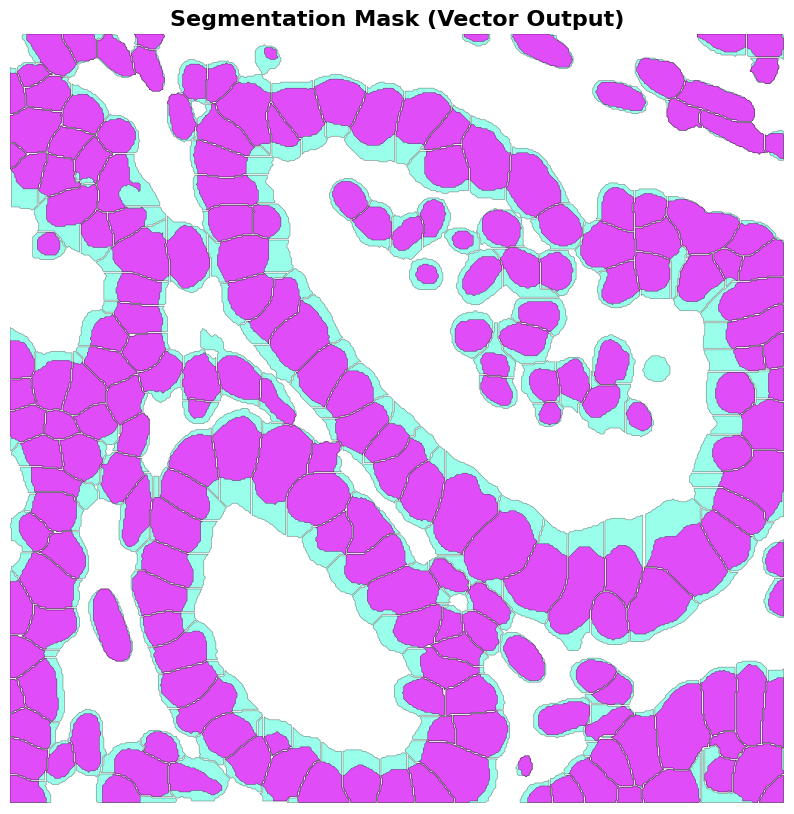

In [6]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np
from PIL import Image

# 1. ILLUSTRATOR COMPATIBILITY & FONTS
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.family'] = "sans-serif"

# 2. COLOR CONFIGURATION (Nature Methods Style)
COLOR_CELL = '#00FFCC'    # Cyan
COLOR_NUCLEI = '#FF00FF'  # Magenta
LINE_COLOR = 'black'      # Sharp black for white background
ALPHA_CELL = 0.4          # Slightly higher for white background clarity
ALPHA_NUCLEI = 0.7

# 3. LOAD DATA
# Update paths as needed for H&E or mIF
IMAGE_PATH = 'test_images/CRC18-he_chunk_0.png'
NUCLEI_GEOJSON = 'results_joint_constrained/nuclei_segmentation.geojson'
CELL_GEOJSON = 'results_joint_constrained/cell_segmentation.geojson'

img = Image.open(IMAGE_PATH)
img_array = np.array(img)
img_height, img_width = img_array.shape[:2]

with open(NUCLEI_GEOJSON, 'r') as f:
    nuclei_data = json.load(f)
with open(CELL_GEOJSON, 'r') as f:
    cell_data = json.load(f)

# 4. PLOTTING
fig, ax = plt.subplots(figsize=(10, 10))

# SET BACKGROUND TO WHITE
ax.set_facecolor('white')

def get_polygons(data):
    patches = []
    for feature in data['features']:
        coords = np.array(feature['geometry']['coordinates'][0], dtype=float)
        if coords.ndim == 3: coords = coords[0]
        if coords.ndim == 2 and coords.shape[1] == 2:
            patches.append(mpatches.Polygon(coords, closed=True))
    return patches

# Add Cells (Vector Layer)
cell_patches = get_polygons(cell_data)
cell_coll = PatchCollection(cell_patches, 
                            facecolors=COLOR_CELL, 
                            alpha=ALPHA_CELL, 
                            edgecolors=LINE_COLOR, 
                            linewidths=0.5,
                            zorder=2) 
ax.add_collection(cell_coll)

# Add Nuclei (Vector Layer)
nuclei_patches = get_polygons(nuclei_data)
nuclei_coll = PatchCollection(nuclei_patches, 
                              facecolors=COLOR_NUCLEI, 
                              alpha=ALPHA_NUCLEI, 
                              edgecolors=LINE_COLOR, 
                              linewidths=0.3,
                              zorder=3)
ax.add_collection(nuclei_coll)

# Final formatting
ax.set_title('Segmentation Mask (Vector Output)', fontsize=16, fontweight='bold')
ax.axis('off')

# Matches the aspect ratio of the original image
ax.set_xlim(0, img_width)
ax.set_ylim(img_height, 0)

# 5. SAVE FOR ILLUSTRATOR
# We set transparent=False to ensure the background is solid white in the PDF
plt.savefig('mask_only_white_bg.pdf', 
            format='pdf', 
            bbox_inches='tight', 
            transparent=False, 
            dpi=300)

print("PDF saved with white background for Adobe Illustrator.")
plt.show()

Done! Objects are now solid and should show fill color immediately.


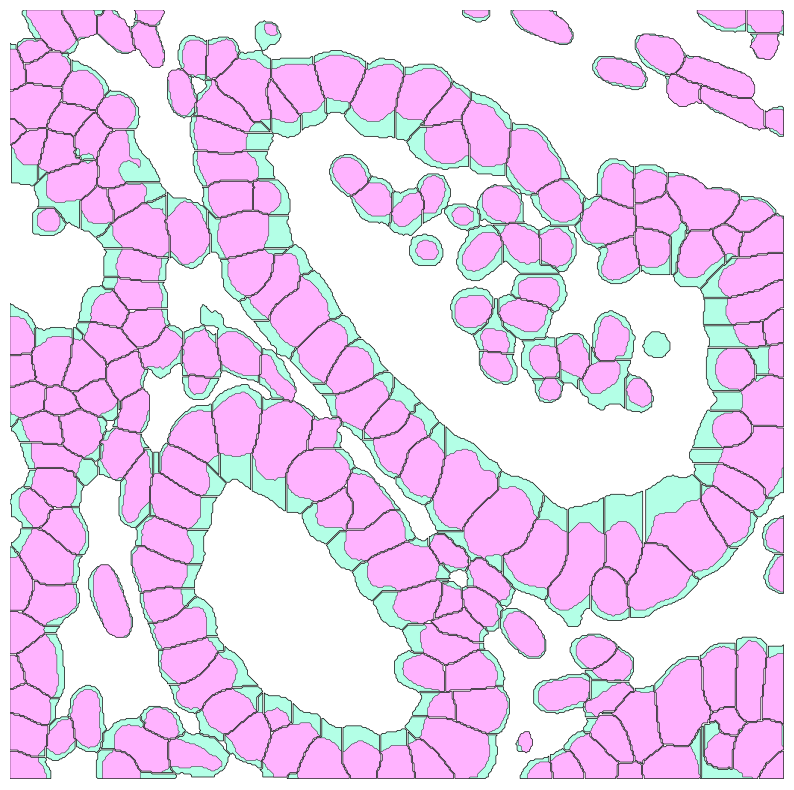

In [9]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image

# 1. ILLUSTRATOR COMPATIBILITY
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']
plt.rcParams['font.family'] = "sans-serif"

# 2. COLOR CONFIGURATION 
# I am using solid hex codes. If you want them lighter, 
# edit these hex codes here instead of using alpha.
COLOR_CELL = '#B3FFE6'    # Solid light Cyan
COLOR_NUCLEI = '#FFB3FF'  # Solid light Magenta
LINE_COLOR = '#000000'    # Pure Black

# 3. LOAD DATA
IMAGE_PATH = 'test_images/CRC18-he_chunk_0.png'
NUCLEI_GEOJSON = 'results_joint_constrained/nuclei_segmentation.geojson'
CELL_GEOJSON = 'results_joint_constrained/cell_segmentation.geojson'

img = Image.open(IMAGE_PATH)
img_width, img_height = img.size

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

nuclei_data = load_json(NUCLEI_GEOJSON)
cell_data = load_json(CELL_GEOJSON)

# 4. PLOTTING
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

def add_clean_patches(data, color, lw, z):
    """Adds polygons as flat, solid-color vector paths"""
    for feature in data['features']:
        coords = np.array(feature['geometry']['coordinates'][0], dtype=float)
        if coords.ndim == 3: coords = coords[0]
        if coords.ndim == 2 and coords.shape[1] == 2:
            poly = mpatches.Polygon(
                coords, 
                closed=True, 
                facecolor=color, # NO ALPHA HERE
                edgecolor=LINE_COLOR, 
                linewidth=lw,
                zorder=z
            )
            ax.add_patch(poly)

# Add Cells then Nuclei
add_clean_patches(cell_data, COLOR_CELL, 0.5, 2)
add_clean_patches(nuclei_data, COLOR_NUCLEI, 0.3, 3)

# Formatting
ax.set_xlim(0, img_width)
ax.set_ylim(img_height, 0)
ax.axis('off')

# 5. EXPORT (CRITICAL SETTINGS)
plt.savefig('clean_selectable_mask.pdf', 
            format='pdf', 
            bbox_inches='tight', 
            transparent=False) # Keep False for white background

print("Done! Objects are now solid and should show fill color immediately.")
plt.show()

## MIf

In [14]:
from vitaminp.inference import WSIPredictor
from vitaminp.inference.channel_config import ChannelConfig

# 1. Setup Channel Config (as before)
config = ChannelConfig(
    nuclear_channel=2,
    membrane_channel=[0, 1],
    membrane_combination='max',
    channel_names={0: 'CellMarker1', 1: 'CellMarker2', 2: 'DAPI'}
)

# 2. Initialize Predictor with BATCH SIZE
# 🚀 This is the only change needed!
predictor = WSIPredictor(
    model=model,
    device='cuda',
    patch_size=512,
    overlap=64,
    target_mpp=0.263,
    magnification=40,
    mif_channel_config=config,
    
    # 🔥 ENABLE BATCHING HERE
    # Start with 16. If you have a large GPU (24GB+), try 32 or 64.
    # If you get "CUDA Out of Memory", lower to 8 or 4.
    batch_size=16  
)

# 3. RUN INFERENCE (The Magic Step)
# By passing BOTH branches, the predictor automatically switches to 
# the new "Joint Inference" mode where Nuclei constrain the Cells.
results = predictor.predict(
    wsi_path='test_images/ovarian-mif_chunk_62_combined.png',
    output_dir='results_joint_constrained/mif',
    
    # [!] THIS TRIGGERS THE NEW LOGIC
    branches=['mif_nuclei', 'mif_cell'], 
    
    # Standard settings
    filter_tissue=False,
    clean_overlaps=True,
    save_geojson=True,
    save_parquet=False,       # Saves fast-loading parquet files
    simplify_epsilon=None,    # Smoother contours
    coord_precision=None,        # Smaller file size
)


2026-02-03 21:18:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-02-03 21:18:54 - WSIPredictor - INFO -   Device: cuda
2026-02-03 21:18:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-02-03 21:18:54 - WSIPredictor - INFO -   Batch Size: 16
2026-02-03 21:18:54 - WSIPredictor - INFO -   MIF Config: Present
2026-02-03 21:18:54 - WSIPredictor - INFO - 🔍 Resolution: MPP=0.2630, scale=1.00x, Batch Size=16
2026-02-03 21:18:54 - WSIPredictor - INFO - 🧠 Running Batch Inference...


   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...


Processing: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
2026-02-03 21:18:54 - WSIPredictor - INFO -    ✓ Extracted 152 instances (before cleaning)
2026-02-03 21:18:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-02-03 21:18:54 - WSIPredictor - INFO -    🔍 Starting with 152 instances
2026-02-03 21:18:54 - WSIPredictor - INFO -    📍 Phase 1: Hard Drop (directional boundary cleaning)
2026-02-03 21:18:54 - WSIPredictor - INFO -    ✓ Hard Drop removed 0, survivors: 152
2026-02-03 21:18:54 - WSIPredictor - INFO -    🔄 Phase 2: Iterative overlap removal
2026-02-03 21:18:54 - WSIPredictor - INFO -       Iteration 1: 0 overlaps, kept 152/152
2026-02-03 21:18:54 - WSIPredictor - INFO -       ✓ Converged!
2026-02-03 21:18:54 - WSIPredictor - INFO -    ✅ Final count: 152 instances
2026-02-03 21:18:54 - WSIPredictor - INFO -    ✓ Removed 0, remaining: 152
2026-02-03 21:18:54 - WSIPredictor - INFO - ✅ mif_nuclei: 152 detections
2026-02-03 21:18:54 - WSIPredic

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


2026-02-03 21:18:55 - WSIPredictor - INFO - ✅ mif_cell: 153 detections


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


Success: Saved to mif_selectable_white_bg.pdf. Every cell is now an individual, solid-filled object.


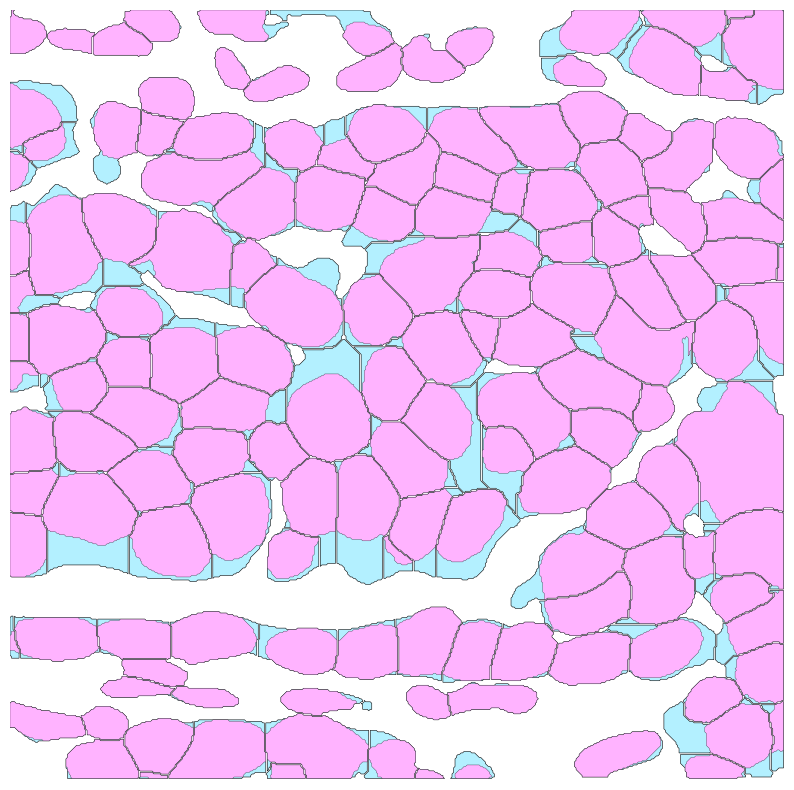

In [10]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image

# --- CONFIGURATION ---
USE_WHITE_BACKGROUND = True 
SAVE_NAME = 'mif_selectable_white_bg.pdf' if USE_WHITE_BACKGROUND else 'mif_selectable_overlay.pdf'

# Illustrator Compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']
plt.rcParams['font.family'] = "sans-serif"

# Colors: Using solid hex codes (No Alpha) for easy selection in Illustrator
# If background is white, these will look like "Pastels"
COLOR_CELL = '#B3F0FF'    # Solid light Cyan
COLOR_NUCLEI = '#FFB3FF'  # Solid light Magenta
LINE_COLOR = 'black' if USE_WHITE_BACKGROUND else 'white'

# --- DATA LOADING ---
img = Image.open('test_images/ovarian-mif_chunk_62_combined.png')
img_array = np.array(img)
img_h, img_w = img_array.shape[:2]

def load_geojson(path):
    with open(path, 'r') as f:
        return json.load(f)

nuclei_data = load_geojson('results_joint_constrained/mif/nuclei_segmentation.geojson')
cell_data = load_geojson('results_joint_constrained/mif/cell_segmentation.geojson')

# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(10, 10))

if not USE_WHITE_BACKGROUND:
    ax.imshow(img_array)
else:
    ax.set_facecolor('white')

def add_individual_patches(data, color, lw, z):
    """Adds each polygon as a clean, solid-color vector path"""
    for feature in data['features']:
        coords = np.array(feature['geometry']['coordinates'][0], dtype=float)
        if coords.ndim == 3: coords = coords[0]
        if coords.ndim == 2 and coords.shape[1] == 2:
            poly = mpatches.Polygon(
                coords, 
                closed=True, 
                facecolor=color, # NO ALPHA for better Illustrator compatibility
                edgecolor=LINE_COLOR, 
                linewidth=lw,
                zorder=z
            )
            ax.add_patch(poly)

# Add Cells (Vector layer)
add_individual_patches(cell_data, COLOR_CELL, 0.4, 2)

# Add Nuclei (Vector layer)
add_individual_patches(nuclei_data, COLOR_NUCLEI, 0.2, 3)

# Clean up axes
ax.axis('off')
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)

# Save for Illustrator
# We use transparent=False to ensure the background layer is predictable
plt.savefig(SAVE_NAME, 
            format='pdf', 
            bbox_inches='tight', 
            transparent=False)

print(f"Success: Saved to {SAVE_NAME}. Every cell is now an individual, solid-filled object.")
plt.show()